In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

    # load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [3]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/기계학습 10주차/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/기계학습 10주차/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [4]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-1874727740.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1874727740.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1874727740.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1874727740.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [5]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]


In [10]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D, LSTM, concatenate
)
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

##Level_1 CNN
inputs = Input(shape=(n_timesteps,n_features))##128,9
CNN1 = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(inputs) ##none,126,128
#maxpool1
pool1 = MaxPooling1D(pool_size=5, strides=2)(CNN1)

##Level_2 LSTM
# layer 1
LSTM2 = LSTM(64,return_sequences=True)(pool1)
# merge2
merged_2 = Dropout(0.2)(LSTM2)

##Level_3
# layer 1
LSTM3 = LSTM(32,return_sequences=False)(merged_2)

##dense layer
dense = Dense(512, activation='relu')(LSTM3)
outputs = Dense(n_outputs, activation='softmax')(dense)

##MODEL
CNN_LSTM_model = Model(inputs, outputs)

CNN_LSTM_model(tf.zeros((1, n_timesteps, n_features)))
CNN_LSTM_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
CNN_LSTM_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 128, 128)       │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 62, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 62, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,382 (333.52 KB)

 Trainable params: 85,382 (333.52 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model_history=CNN_LSTM_model.fit(x=X_train, y=y_train_one_hot, epochs=30, batch_size=32,validation_split=0.1)


Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5789 - loss: 1.0348 - val_accuracy: 0.8506 - val_loss: 0.3836
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8653 - loss: 0.3704 - val_accuracy: 0.9134 - val_loss: 0.2231
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9165 - loss: 0.2260 - val_accuracy: 0.9066 - val_loss: 0.2878
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9367 - loss: 0.1818 - val_accuracy: 0.9508 - val_loss: 0.1357
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9465 - loss: 0.1283 - val_accuracy: 0.9491 - val_loss: 0.1145
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9433 - loss: 0.1378 - val_accuracy: 0.9457 - val_loss: 0.1152
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9434 - loss: 0.1471 - val_accuracy: 0.9457 - val_loss: 0.1097
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9544 - loss: 0.1109 - val_accu

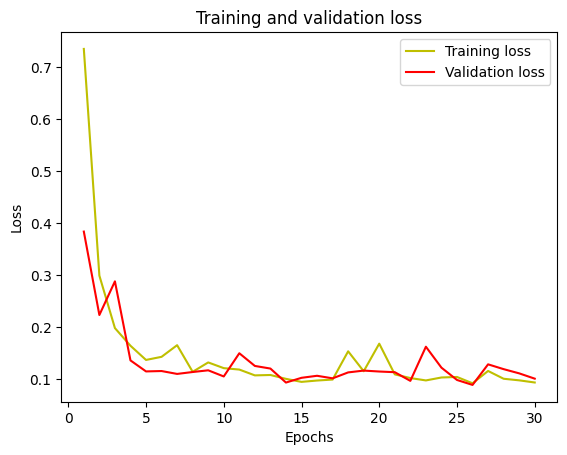

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

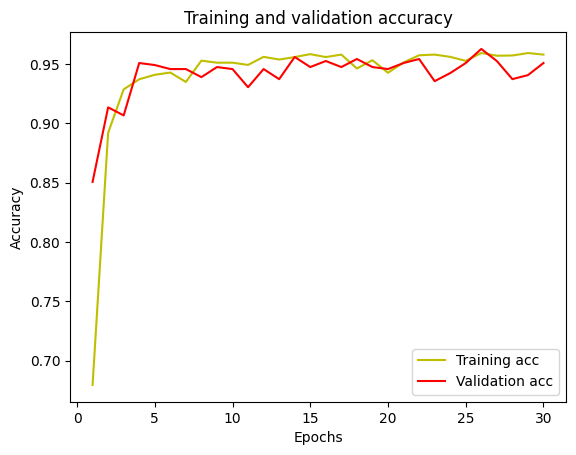

In [13]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()